In [1]:
import os
import argparse
import numpy as np
import pandas as pd
import gc
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
from tabulate import tabulate


In [2]:
# ---------------------------
# Utility Functions
# ---------------------------
def process_classes(data_path, file_name):
    """
    Reads a text file containing class mappings: each line is "<index> <class_name>".
    Returns a dictionary {index: class_name}.
    """
    file_path = os.path.join(data_path, file_name + '.txt')
    classes = {}
    with open(file_path, 'r') as f:
        for line in f:
            index, label = line.strip().split(' ', 1)
            classes[int(index)] = label
    return classes

def find_invalid_filenames(df, base_dir):
    """
    Checks if image files exist in the base_dir. Returns a list of filenames that are invalid.
    """
    invalid_files = []
    for filename in df['filename']:
        file_path = os.path.join(base_dir, filename)
        if not os.path.isfile(file_path):
            invalid_files.append(filename)
    return invalid_files

def visualize_data(df_train, df_valid, column, classes_dict):
    """
    Plots a bar chart of the combined distribution of a specific column (genre/style/artist)
    across train and valid sets.
    """
    combined_counts = df_train[column].value_counts().add(df_valid[column].value_counts(), fill_value=0)
    combined_counts.sort_index().plot(kind='bar', figsize=(8, 4), legend=False)
    plt.title(f"Number of Images per {column}")
    plt.ylabel("Number of Images")
    plt.xlabel(f"{column} (class index)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """
    Plots a confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


In [3]:
# ---------------------------
# Custom PyTorch Dataset
# ---------------------------
class ArtDataset(Dataset):
    """
    Expects a DataFrame with columns:
      - filename: image filename (relative to img_dir)
      - genre, style, artist: integer labels.
    """
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        style = int(row['style'])
        genre = int(row['genre'])
        artist = int(row['artist'])
        return image, style, genre, artist, row['filename']


In [4]:
# ---------------------------
# Convolutional-Recurrent Model
# ---------------------------
class ConvRNNClassifier(nn.Module):
    """
    Convolutional + LSTM-based model. We use a ResNet50 backbone (pretrained),
    remove the last FC layer, and feed the extracted feature map into an LSTM.
    The final LSTM hidden state is used by separate heads for style, genre, and artist classification.
    """
    def __init__(self, num_styles, num_genres, num_artists, hidden_size=256, lstm_layers=1):
        super(ConvRNNClassifier, self).__init__()
        
        # Use a pretrained ResNet50 as the backbone
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Remove its average pool + final FC layers
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        # Adaptive pool to a fixed size, then LSTM expects (batch, sequence_length, features)
        self.pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # The pooled feature map is (batch, 2048, 7, 7) => reshape => (batch, 49, 2048)
        self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden_size, num_layers=lstm_layers, batch_first=True)
        
        # Separate linear heads
        self.fc_style = nn.Linear(hidden_size, num_styles)
        self.fc_genre = nn.Linear(hidden_size, num_genres)
        self.fc_artist = nn.Linear(hidden_size, num_artists)

    def forward(self, x):
        batch_size = x.size(0)
        
        # CNN
        features = self.cnn(x)                # (B, 2048, H, W)
        features = self.pool(features)        # (B, 2048, 7, 7)
        
        # Reshape: (B, 2048, 7*7) => (B, 49, 2048)
        features = features.view(batch_size, 2048, -1).permute(0, 2, 1)
        
        # LSTM
        lstm_out, (h_n, _) = self.lstm(features)
        final_feature = h_n[-1]               # (B, hidden_size)
        
        # Classifier heads
        out_style = self.fc_style(final_feature)
        out_genre = self.fc_genre(final_feature)
        out_artist = self.fc_artist(final_feature)
        
        return out_style, out_genre, out_artist


In [5]:
# ---------------------------
# Outlier Detection
# ---------------------------
def detect_outliers(
    model, dataloader, device, 
    style_encoder, genre_encoder, artist_encoder, 
    style_classes, genre_classes, artist_classes, 
    threshold=0.3
):
    """
    Detect outliers by checking the model's confidence (softmax probability) on the "true" label.
    If confidence < threshold for style or genre or artist, we mark it as a potential outlier.
    Returns a DataFrame with potential outliers.
    """
    model.eval()
    outliers = []
    
    with torch.no_grad():
        for images, style_labels, genre_labels, artist_labels, filenames in dataloader:
            images = images.to(device)
            style_labels = style_labels.to(device)
            genre_labels = genre_labels.to(device)
            artist_labels = artist_labels.to(device)
            
            out_style, out_genre, out_artist = model(images)
            
            # Convert outputs to probabilities
            probs_style = F.softmax(out_style, dim=1)
            probs_genre = F.softmax(out_genre, dim=1)
            probs_artist = F.softmax(out_artist, dim=1)
            
            # Check each sample in the batch
            for i in range(images.size(0)):
                style_conf = probs_style[i, style_labels[i]].item()
                genre_conf = probs_genre[i, genre_labels[i]].item()
                artist_conf = probs_artist[i, artist_labels[i]].item()
                
                # If any of these is below threshold, consider it outlier
                if (style_conf < threshold) or (genre_conf < threshold) or (artist_conf < threshold):
                    # Convert numeric label back to class names
                    style_name = style_classes[style_encoder.inverse_transform([style_labels[i].item()])[0]]
                    genre_name = genre_classes[genre_encoder.inverse_transform([genre_labels[i].item()])[0]]
                    artist_name = artist_classes[artist_encoder.inverse_transform([artist_labels[i].item()])[0]]
                    
                    outliers.append({
                        'filename': filenames[i],
                        'style': style_name,
                        'genre': genre_name,
                        'artist': artist_name,
                        'style_confidence': style_conf,
                        'genre_confidence': genre_conf,
                        'artist_confidence': artist_conf
                    })
    
    return pd.DataFrame(outliers)


In [6]:
# ---------------------------
# Main Pipeline
# ---------------------------
def main(args):
    """
    Main training + evaluation pipeline.
    1. Read class definitions and CSV files.
    2. Clean data (remove invalid filenames).
    3. Encode labels consistently.
    4. Build and train ConvRNN model.
    5. Evaluate and plot results.
    6. Detect and visualize outliers.
    """
    
    # Paths in your Kaggle environment
    datapath = '/kaggle/input/wikiart'       # All images located here
    genres_datapath = '/kaggle/input/genres-ds'
    styles_datapath = '/kaggle/input/style-ds'
    artist_datapath = '/kaggle/input/gsocdata'
    
    # 1. Read class mappings
    genres_classes = process_classes(genres_datapath, 'genre_class')
    styles_classes = process_classes(styles_datapath, 'style_class')
    artist_classes = process_classes(artist_datapath, 'artist_class')
    print("Class Mappings:")
    print(f"Genres:  {len(genres_classes)} classes")
    print(f"Styles:  {len(styles_classes)} classes")
    print(f"Artists: {len(artist_classes)} classes\n")

    # 2. Read CSVs for train/val splits
    genre_data_train = pd.read_csv(os.path.join(genres_datapath, 'genre_train.csv'))
    genre_data_valid = pd.read_csv(os.path.join(genres_datapath, 'genre_val.csv'))

    style_data_train = pd.read_csv(
        os.path.join(styles_datapath, 'style_train.csv'), header=None, names=['filename', 'style']
    )
    style_data_valid = pd.read_csv(
        os.path.join(styles_datapath, 'style_val.csv'),   header=None, names=['filename', 'style']
    )

    artist_data_train = pd.read_csv(
        os.path.join(artist_datapath, 'artist_train.csv'), header=None, names=['filename', 'artist']
    )
    artist_data_valid = pd.read_csv(
        os.path.join(artist_datapath, 'artist_val.csv'),   header=None, names=['filename', 'artist']
    )

    # Merge datasets on "filename"
    data_train = pd.merge(genre_data_train, style_data_train, on='filename', suffixes=('_genre', '_style'))
    data_train = pd.merge(data_train, artist_data_train, on='filename')
    
    data_valid = pd.merge(genre_data_valid, style_data_valid, on='filename', suffixes=('_genre', '_style'))
    data_valid = pd.merge(data_valid, artist_data_valid, on='filename')

    print("Sample of Merged Train Data:")
    print(data_train.head(), "\n")

    # Quick check for missing values
    print("Missing values in train:\n", data_train.isnull().sum(), "\n")
    print("Missing values in valid:\n", data_valid.isnull().sum(), "\n")

    # Check and remove invalid files
    invalid_train = find_invalid_filenames(data_train, datapath)
    invalid_valid = find_invalid_filenames(data_valid, datapath)
    print(f"Invalid train files: {len(invalid_train)}")
    print(f"Invalid valid files: {len(invalid_valid)}")

    data_train_cleaned = data_train[~data_train['filename'].isin(invalid_train)]
    data_valid_cleaned = data_valid[~data_valid['filename'].isin(invalid_valid)]
    print(f"Train set size after cleaning: {len(data_train_cleaned)}")
    print(f"Valid set size after cleaning: {len(data_valid_cleaned)}\n")

    # Visualize distributions
    visualize_data(data_train_cleaned, data_valid_cleaned, 'genre', genres_classes)
    visualize_data(data_train_cleaned, data_valid_cleaned, 'style', styles_classes)
    visualize_data(data_train_cleaned, data_valid_cleaned, 'artist', artist_classes)

    # ---------------------------
    # 3. Label Encoding
    # ---------------------------
    combined_data = pd.concat([data_train_cleaned, data_valid_cleaned])

    style_encoder = LabelEncoder()
    genre_encoder = LabelEncoder()
    artist_encoder = LabelEncoder()

    style_encoder.fit(combined_data['style'])
    genre_encoder.fit(combined_data['genre'])
    artist_encoder.fit(combined_data['artist'])

    # Apply transform
    data_train_cleaned.loc[:, 'style'] = style_encoder.transform(data_train_cleaned['style'])
    data_train_cleaned.loc[:, 'genre'] = genre_encoder.transform(data_train_cleaned['genre'])
    data_train_cleaned.loc[:, 'artist'] = artist_encoder.transform(data_train_cleaned['artist'])

    data_valid_cleaned.loc[:, 'style'] = style_encoder.transform(data_valid_cleaned['style'])
    data_valid_cleaned.loc[:, 'genre'] = genre_encoder.transform(data_valid_cleaned['genre'])
    data_valid_cleaned.loc[:, 'artist'] = artist_encoder.transform(data_valid_cleaned['artist'])

    num_styles = len(style_encoder.classes_)
    num_genres = len(genre_encoder.classes_)
    num_artists = len(artist_encoder.classes_)

    print("Encoded Label Ranges:")
    print(f" Style labels: 0 to {num_styles-1}")
    print(f" Genre labels: 0 to {num_genres-1}")
    print(f" Artist labels: 0 to {num_artists-1}\n")

    # ---------------------------
    # Train / Valid / Test Split
    # ---------------------------
    train_data_split, temp_data = train_test_split(
        data_train_cleaned,
        test_size=0.30,
        random_state=42,
        stratify=data_train_cleaned['genre']
    )
    valid_data_split, test_data = train_test_split(
        temp_data,
        test_size=0.5,
        random_state=42
    )

    print("Data splits after custom split:")
    print(f" Train: {train_data_split.shape[0]} samples")
    print(f" Validation: {valid_data_split.shape[0]} samples")
    print(f" Test: {test_data.shape[0]} samples\n")

    # ---------------------------
    # Weighted Sampler for Imbalance
    # ---------------------------
    genre_counts = train_data_split['genre'].value_counts().to_dict()
    weights = train_data_split['genre'].apply(lambda x: 1.0 / genre_counts[x]).values
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    # Free up GPU memory if needed
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device:", device, "\n")

    # ---------------------------
    # 4. Image Transforms
    # ---------------------------
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((args.img_size, args.img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # ---------------------------
    # 5. Datasets and Loaders
    # ---------------------------
    train_dataset = ArtDataset(train_data_split, datapath, transform=train_transform)
    valid_dataset = ArtDataset(valid_data_split, datapath, transform=val_transform)
    test_dataset  = ArtDataset(test_data,        datapath, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, sampler=sampler, num_workers=4)
    train_eval_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
    test_loader  = DataLoader(test_dataset,  batch_size=args.batch_size, shuffle=False, num_workers=4)

    # ---------------------------
    # 6. Initialize Model, Optimizer, Loss
    # ---------------------------
    model = ConvRNNClassifier(
        num_styles=num_styles,
        num_genres=num_genres,
        num_artists=num_artists,
        hidden_size=256,
        lstm_layers=1
    )
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    criterion = nn.CrossEntropyLoss()

    # ---------------------------
    # 7. Training Loop
    # ---------------------------
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_style_acc': [],
        'train_genre_acc': [],
        'train_artist_acc': [],
        'val_style_acc': [],
        'val_genre_acc': [],
        'val_artist_acc': []
    }

    for epoch in range(args.epochs):
        model.train()
        running_loss = 0.0
        
        # Mini-batch training
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{args.epochs}")
        for i, (images, style_labels, genre_labels, artist_labels, _) in pbar:
            images = images.to(device)
            style_labels = style_labels.to(device)
            genre_labels = genre_labels.to(device)
            artist_labels = artist_labels.to(device)

            optimizer.zero_grad()

            out_style, out_genre, out_artist = model(images)
            loss_style  = criterion(out_style,  style_labels)
            loss_genre  = criterion(out_genre,  genre_labels)
            loss_artist = criterion(out_artist, artist_labels)
            loss = loss_style + loss_genre + loss_artist
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        avg_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_loss)
        
        print(f"\n[Epoch {epoch+1}/{args.epochs}] Training Average Loss: {avg_loss:.4f}")

        # Evaluate on the entire training set for metrics (optional but helps track overfitting)
        model.eval()
        all_train_style_preds, all_train_genre_preds, all_train_artist_preds = [], [], []
        all_train_style_labels, all_train_genre_labels, all_train_artist_labels = [], [], []

        with torch.no_grad():
            for images, style_labels, genre_labels, artist_labels, _ in train_eval_loader:
                images = images.to(device)
                style_labels = style_labels.to(device)
                genre_labels = genre_labels.to(device)
                artist_labels = artist_labels.to(device)
                
                out_style, out_genre, out_artist = model(images)
                
                pred_style  = torch.argmax(F.softmax(out_style,  dim=1), dim=1)
                pred_genre  = torch.argmax(F.softmax(out_genre,  dim=1), dim=1)
                pred_artist = torch.argmax(F.softmax(out_artist, dim=1), dim=1)
                
                all_train_style_preds.extend(pred_style.cpu().numpy())
                all_train_genre_preds.extend(pred_genre.cpu().numpy())
                all_train_artist_preds.extend(pred_artist.cpu().numpy())
                
                all_train_style_labels.extend(style_labels.cpu().numpy())
                all_train_genre_labels.extend(genre_labels.cpu().numpy())
                all_train_artist_labels.extend(artist_labels.cpu().numpy())

        train_acc_style  = accuracy_score(all_train_style_labels,  all_train_style_preds)
        train_acc_genre  = accuracy_score(all_train_genre_labels,  all_train_genre_preds)
        train_acc_artist = accuracy_score(all_train_artist_labels, all_train_artist_preds)
        
        history['train_style_acc'].append(train_acc_style)
        history['train_genre_acc'].append(train_acc_genre)
        history['train_artist_acc'].append(train_acc_artist)
        
        print("Training Metrics:")
        print(f"  Style  - Accuracy: {train_acc_style:.4f}")
        print(f"  Genre  - Accuracy: {train_acc_genre:.4f}")
        print(f"  Artist - Accuracy: {train_acc_artist:.4f}\n")

        # Validation Phase
        val_loss = 0.0
        all_style_preds, all_genre_preds, all_artist_preds = [], [], []
        all_style_labels, all_genre_labels, all_artist_labels = [], [], []

        with torch.no_grad():
            for images, style_labels, genre_labels, artist_labels, _ in valid_loader:
                images = images.to(device)
                style_labels = style_labels.to(device)
                genre_labels = genre_labels.to(device)
                artist_labels = artist_labels.to(device)
                
                out_style, out_genre, out_artist = model(images)
                
                loss_style  = criterion(out_style,  style_labels)
                loss_genre  = criterion(out_genre,  genre_labels)
                loss_artist = criterion(out_artist, artist_labels)
                
                val_loss += (loss_style + loss_genre + loss_artist).item()
                
                pred_style  = torch.argmax(F.softmax(out_style,  dim=1), dim=1)
                pred_genre  = torch.argmax(F.softmax(out_genre,  dim=1), dim=1)
                pred_artist = torch.argmax(F.softmax(out_artist, dim=1), dim=1)
                
                all_style_preds.extend(pred_style.cpu().numpy())
                all_genre_preds.extend(pred_genre.cpu().numpy())
                all_artist_preds.extend(pred_artist.cpu().numpy())
                
                all_style_labels.extend(style_labels.cpu().numpy())
                all_genre_labels.extend(genre_labels.cpu().numpy())
                all_artist_labels.extend(artist_labels.cpu().numpy())

        avg_val_loss = val_loss / len(valid_loader)
        history['val_loss'].append(avg_val_loss)

        acc_style  = accuracy_score(all_style_labels,  all_style_preds)
        acc_genre  = accuracy_score(all_genre_labels,  all_genre_preds)
        acc_artist = accuracy_score(all_artist_labels, all_artist_preds)

        history['val_style_acc'].append(acc_style)
        history['val_genre_acc'].append(acc_genre)
        history['val_artist_acc'].append(acc_artist)

        print(f"Validation Loss: {avg_val_loss:.4f}")
        print("Validation Metrics:")
        print(f"  Style  - Accuracy: {acc_style:.4f}")
        print(f"  Genre  - Accuracy: {acc_genre:.4f}")
        print(f"  Artist - Accuracy: {acc_artist:.4f}\n")

        # Save checkpoint
        checkpoint_path = f"conv_rnn_classifier_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_loss,
            'val_loss': avg_val_loss,
            'val_acc_style': acc_style,
            'val_acc_genre': acc_genre,
            'val_acc_artist': acc_artist,
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}\n{'-'*50}")

    # ---------------------------
    # 8. Save Final Model
    # ---------------------------
    torch.save(model.state_dict(), "conv_rnn_classifier_final.pth")
    print("\nTraining complete. Final model saved as conv_rnn_classifier_final.pth\n")

    # ---------------------------
    # 9. Plot Training History
    # ---------------------------
    plt.figure(figsize=(12, 4))
    
    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'],   label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    
    # Accuracy curves (just for style, genre, artist on validation)
    plt.subplot(1, 2, 2)
    plt.plot(history['val_style_acc'],  label='Style Acc')
    plt.plot(history['val_genre_acc'],  label='Genre Acc')
    plt.plot(history['val_artist_acc'], label='Artist Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

    # ---------------------------
    # 10. Final Evaluation on Test Set
    # ---------------------------
    model.eval()
    all_test_style_preds, all_test_genre_preds, all_test_artist_preds = [], [], []
    all_test_style_labels, all_test_genre_labels, all_test_artist_labels = [], [], []

    with torch.no_grad():
        for images, style_labels, genre_labels, artist_labels, _ in test_loader:
            images = images.to(device)
            style_labels = style_labels.to(device)
            genre_labels = genre_labels.to(device)
            artist_labels = artist_labels.to(device)
            
            out_style, out_genre, out_artist = model(images)
            
            pred_style  = torch.argmax(F.softmax(out_style,  dim=1), dim=1)
            pred_genre  = torch.argmax(F.softmax(out_genre,  dim=1), dim=1)
            pred_artist = torch.argmax(F.softmax(out_artist, dim=1), dim=1)
            
            all_test_style_preds.extend(pred_style.cpu().numpy())
            all_test_genre_preds.extend(pred_genre.cpu().numpy())
            all_test_artist_preds.extend(pred_artist.cpu().numpy())
            
            all_test_style_labels.extend(style_labels.cpu().numpy())
            all_test_genre_labels.extend(genre_labels.cpu().numpy())
            all_test_artist_labels.extend(artist_labels.cpu().numpy())

    test_acc_style  = accuracy_score(all_test_style_labels,  all_test_style_preds)
    test_acc_genre  = accuracy_score(all_test_genre_labels,  all_test_genre_preds)
    test_acc_artist = accuracy_score(all_test_artist_labels, all_test_artist_preds)

    print("\nFinal Test Set Performance:")
    print(f" Style  - Accuracy: {test_acc_style:.4f}")
    print(f" Genre  - Accuracy: {test_acc_genre:.4f}")
    print(f" Artist - Accuracy: {test_acc_artist:.4f}")

    # (Optional) Plot a confusion matrix for style on test set, focusing on the top 10 classes
    style_class_names = [styles_classes[style_encoder.inverse_transform([i])[0]] for i in range(num_styles)]
    
    # We pick top 10 style classes by their frequency in the test set
    style_counts_test = pd.Series(all_test_style_labels).value_counts().sort_values(ascending=False)
    top_10_styles = style_counts_test.head(10).index
    mask_top_10 = np.isin(all_test_style_labels, top_10_styles)

    plot_confusion_matrix(
        np.array(all_test_style_labels)[mask_top_10],
        np.array(all_test_style_preds)[mask_top_10],
        [style_class_names[i] for i in top_10_styles],
        title='Style Confusion Matrix (Top 10 on Test Set)'
    )

    # ---------------------------
    # 11. Outlier Detection
    # ---------------------------
    print("\n--- Outlier Detection on Test Set ---")
    outliers_df = detect_outliers(
        model, test_loader, device,
        style_encoder, genre_encoder, artist_encoder,
        styles_classes, genres_classes, artist_classes,
        threshold=0.3
    )

    if len(outliers_df) == 0:
        print("No outliers detected with the current threshold.")
        return

    # Sort outliers by minimum confidence
    outliers_df['min_confidence'] = outliers_df[['style_confidence','genre_confidence','artist_confidence']].min(axis=1)
    outliers_df = outliers_df.sort_values('min_confidence')

    print(f"Found {len(outliers_df)} potential outliers.")
    print("Top 10 outliers (lowest confidence):\n")
    print(tabulate(outliers_df.head(10), headers='keys', tablefmt='psql'))

    # Save full outliers as CSV
    outliers_df.to_csv('art_outliers.csv', index=False)
    print("\nFull outlier list saved to 'art_outliers.csv'")

    # ---------------------------
    # 12. Visualize Some Outliers
    # ---------------------------
    # Display the first 6 outliers in a 2-row x 3-column grid
    outliers_to_show = outliers_df.head(6)
    plt.figure(figsize=(12, 8))
    for idx, (_, row) in enumerate(outliers_to_show.iterrows()):
        plt.subplot(2, 3, idx+1)
        img_path = os.path.join(datapath, row['filename'])
        img = Image.open(img_path).convert('RGB')
        plt.imshow(img)
        plt.title(
            f"Artist: {row['artist']}\n"
            f"Genre: {row['genre']}\n"
            f"Style: {row['style']}\n"
            f"Conf: {row['min_confidence']:.2f}"
        )
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('outlier_samples.png')
    plt.show()


Running on device: cuda
Class Mappings:
Genres:  10 classes
Styles:  27 classes
Artists: 23 classes

Sample of Merged Train Data:
                                            filename  genre  style  artist
0  Post_Impressionism/vincent-van-gogh_ears-of-wh...      4     20      22
1  Expressionism/martiros-saryan_mother-of-the-ar...      6      9      13
2  Naive_Art_Primitivism/marc-chagall_clown-with-...      2     15      12
3  Northern_Renaissance/albrecht-durer_temptation...      7     17       0
4  Impressionism/pierre-auguste-renoir_woman-with...      6     12      17 

Missing values in train:
 filename    0
genre       0
style       0
artist      0
dtype: int64 

Missing values in valid:
 filename    0
genre       0
style       0
artist      0
dtype: int64 

Invalid train files: 2
Invalid valid files: 0
Train set size after cleaning: 11274
Valid set size after cleaning: 4707



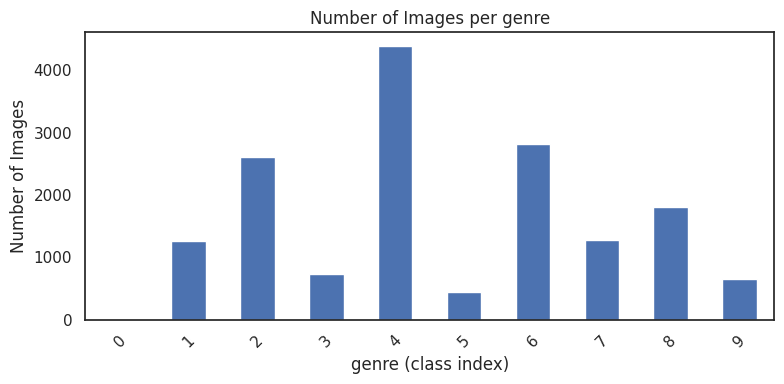

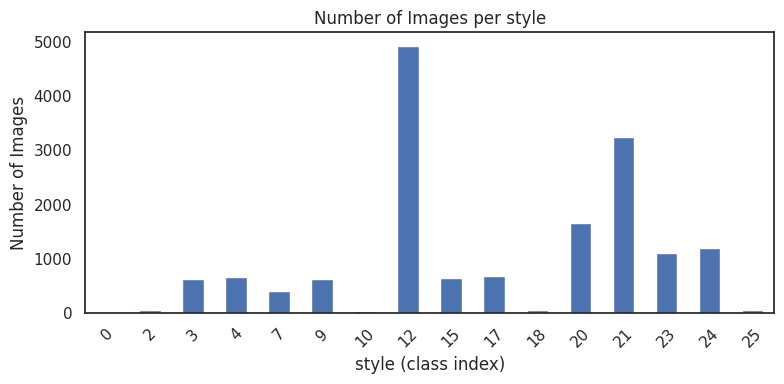

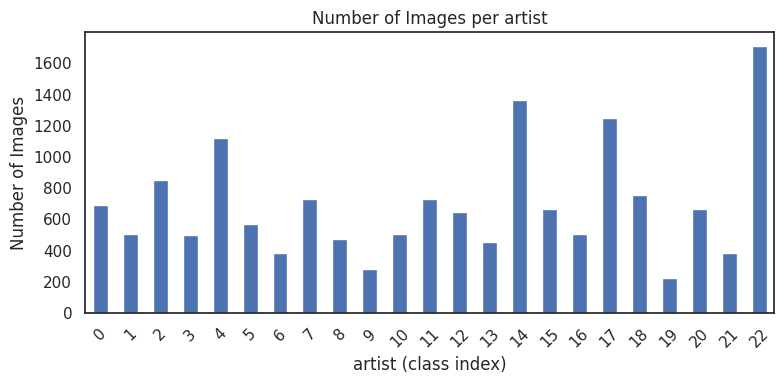

Encoded Label Ranges:
 Style labels: 0 to 15
 Genre labels: 0 to 9
 Artist labels: 0 to 22

Data splits after custom split:
 Train: 7891 samples
 Validation: 1691 samples
 Test: 1692 samples

Using device: cuda:0 



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]
Epoch 1/12: 100%|██████████| 987/987 [02:18<00:00,  7.11it/s, loss=8.0887]


[Epoch 1/12] Training Average Loss: 7.1167


Training Metrics:
  Style  - Accuracy: 0.3589
  Genre  - Accuracy: 0.2420
  Artist - Accuracy: 0.1225

Validation Loss: 6.9881
Validation Metrics:
  Style  - Accuracy: 0.3708
  Genre  - Accuracy: 0.2431
  Artist - Accuracy: 0.1378

Checkpoint saved: conv_rnn_classifier_epoch_1.pth
--------------------------------------------------


Epoch 2/12: 100%|██████████| 987/987 [02:06<00:00,  7.79it/s, loss=7.5645]


[Epoch 2/12] Training Average Loss: 6.7283


Training Metrics:
  Style  - Accuracy: 0.3466
  Genre  - Accuracy: 0.1745
  Artist - Accuracy: 0.1608

Validation Loss: 6.9746
Validation Metrics:
  Style  - Accuracy: 0.3566
  Genre  - Accuracy: 0.1685
  Artist - Accuracy: 0.1685

Checkpoint saved: conv_rnn_classifier_epoch_2.pth
--------------------------------------------------


Epoch 3/12: 100%|██████████| 987/987 [02:12<00:00,  7.46it/s, loss=7.3311] 


[Epoch 3/12] Training Average Loss: 6.3462


Training Metrics:
  Style  - Accuracy: 0.3523
  Genre  - Accuracy: 0.2153
  Artist - Accuracy: 0.1729

Validation Loss: 6.8782
Validation Metrics:
  Style  - Accuracy: 0.3666
  Genre  - Accuracy: 0.2247
  Artist - Accuracy: 0.1768

Checkpoint saved: conv_rnn_classifier_epoch_3.pth
--------------------------------------------------


Epoch 4/12: 100%|██████████| 987/987 [02:13<00:00,  7.39it/s, loss=6.8357]


[Epoch 4/12] Training Average Loss: 6.2625


Training Metrics:
  Style  - Accuracy: 0.3572
  Genre  - Accuracy: 0.2139
  Artist - Accuracy: 0.1637

Validation Loss: 6.8642
Validation Metrics:
  Style  - Accuracy: 0.3720
  Genre  - Accuracy: 0.2034
  Artist - Accuracy: 0.1739

Checkpoint saved: conv_rnn_classifier_epoch_4.pth
--------------------------------------------------


Epoch 5/12: 100%|██████████| 987/987 [02:06<00:00,  7.78it/s, loss=6.7238]


[Epoch 5/12] Training Average Loss: 6.2257


Training Metrics:
  Style  - Accuracy: 0.3709
  Genre  - Accuracy: 0.2310
  Artist - Accuracy: 0.1653

Validation Loss: 6.8287
Validation Metrics:
  Style  - Accuracy: 0.3702
  Genre  - Accuracy: 0.2519
  Artist - Accuracy: 0.1709

Checkpoint saved: conv_rnn_classifier_epoch_5.pth
--------------------------------------------------


Epoch 6/12: 100%|██████████| 987/987 [02:11<00:00,  7.53it/s, loss=7.0139]


[Epoch 6/12] Training Average Loss: 6.0472


Training Metrics:
  Style  - Accuracy: 0.3599
  Genre  - Accuracy: 0.1990
  Artist - Accuracy: 0.1710

Validation Loss: 6.7199
Validation Metrics:
  Style  - Accuracy: 0.3678
  Genre  - Accuracy: 0.1999
  Artist - Accuracy: 0.1851

Checkpoint saved: conv_rnn_classifier_epoch_6.pth
--------------------------------------------------


Epoch 7/12: 100%|██████████| 987/987 [02:07<00:00,  7.74it/s, loss=6.9427] 


[Epoch 7/12] Training Average Loss: 6.0116


Training Metrics:
  Style  - Accuracy: 0.3561
  Genre  - Accuracy: 0.2094
  Artist - Accuracy: 0.1926

Validation Loss: 6.6525
Validation Metrics:
  Style  - Accuracy: 0.3684
  Genre  - Accuracy: 0.2022
  Artist - Accuracy: 0.1904

Checkpoint saved: conv_rnn_classifier_epoch_7.pth
--------------------------------------------------


Epoch 8/12: 100%|██████████| 987/987 [02:06<00:00,  7.78it/s, loss=3.7691]


[Epoch 8/12] Training Average Loss: 5.9327


Training Metrics:
  Style  - Accuracy: 0.3759
  Genre  - Accuracy: 0.2607
  Artist - Accuracy: 0.1877

Validation Loss: 6.5923
Validation Metrics:
  Style  - Accuracy: 0.3933
  Genre  - Accuracy: 0.2720
  Artist - Accuracy: 0.2070

Checkpoint saved: conv_rnn_classifier_epoch_8.pth
--------------------------------------------------


Epoch 9/12: 100%|██████████| 987/987 [02:10<00:00,  7.58it/s, loss=7.5106]


[Epoch 9/12] Training Average Loss: 5.8745


Training Metrics:
  Style  - Accuracy: 0.3741
  Genre  - Accuracy: 0.2529
  Artist - Accuracy: 0.1889

Validation Loss: 6.6160
Validation Metrics:
  Style  - Accuracy: 0.3737
  Genre  - Accuracy: 0.2584
  Artist - Accuracy: 0.1863

Checkpoint saved: conv_rnn_classifier_epoch_9.pth
--------------------------------------------------


Epoch 10/12: 100%|██████████| 987/987 [02:07<00:00,  7.73it/s, loss=7.2407]


[Epoch 10/12] Training Average Loss: 5.9147


Training Metrics:
  Style  - Accuracy: 0.3716
  Genre  - Accuracy: 0.2191
  Artist - Accuracy: 0.1954

Validation Loss: 6.7555
Validation Metrics:
  Style  - Accuracy: 0.3826
  Genre  - Accuracy: 0.2017
  Artist - Accuracy: 0.2040

Checkpoint saved: conv_rnn_classifier_epoch_10.pth
--------------------------------------------------


Epoch 11/12: 100%|██████████| 987/987 [02:07<00:00,  7.75it/s, loss=5.6487] 


[Epoch 11/12] Training Average Loss: 5.8528


Training Metrics:
  Style  - Accuracy: 0.3707
  Genre  - Accuracy: 0.2384
  Artist - Accuracy: 0.1963

Validation Loss: 6.6090
Validation Metrics:
  Style  - Accuracy: 0.3726
  Genre  - Accuracy: 0.2182
  Artist - Accuracy: 0.2011

Checkpoint saved: conv_rnn_classifier_epoch_11.pth
--------------------------------------------------


Epoch 12/12: 100%|██████████| 987/987 [02:04<00:00,  7.92it/s, loss=2.9957] 


[Epoch 12/12] Training Average Loss: 5.8157


Training Metrics:
  Style  - Accuracy: 0.3708
  Genre  - Accuracy: 0.3024
  Artist - Accuracy: 0.1858

Validation Loss: 6.5672
Validation Metrics:
  Style  - Accuracy: 0.3879
  Genre  - Accuracy: 0.3069
  Artist - Accuracy: 0.1910

Checkpoint saved: conv_rnn_classifier_epoch_12.pth
--------------------------------------------------

Training complete. Final model saved as conv_rnn_classifier_final.pth



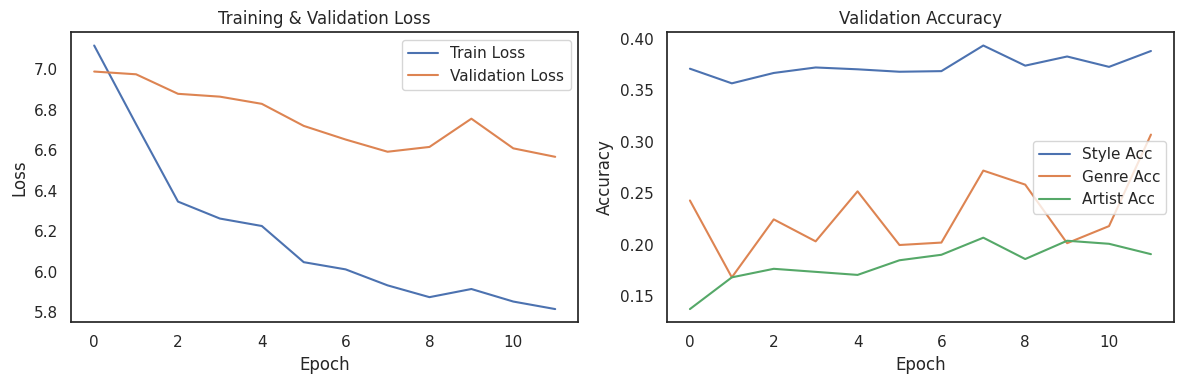


Final Test Set Performance:
 Style  - Accuracy: 0.3635
 Genre  - Accuracy: 0.2979
 Artist - Accuracy: 0.1950


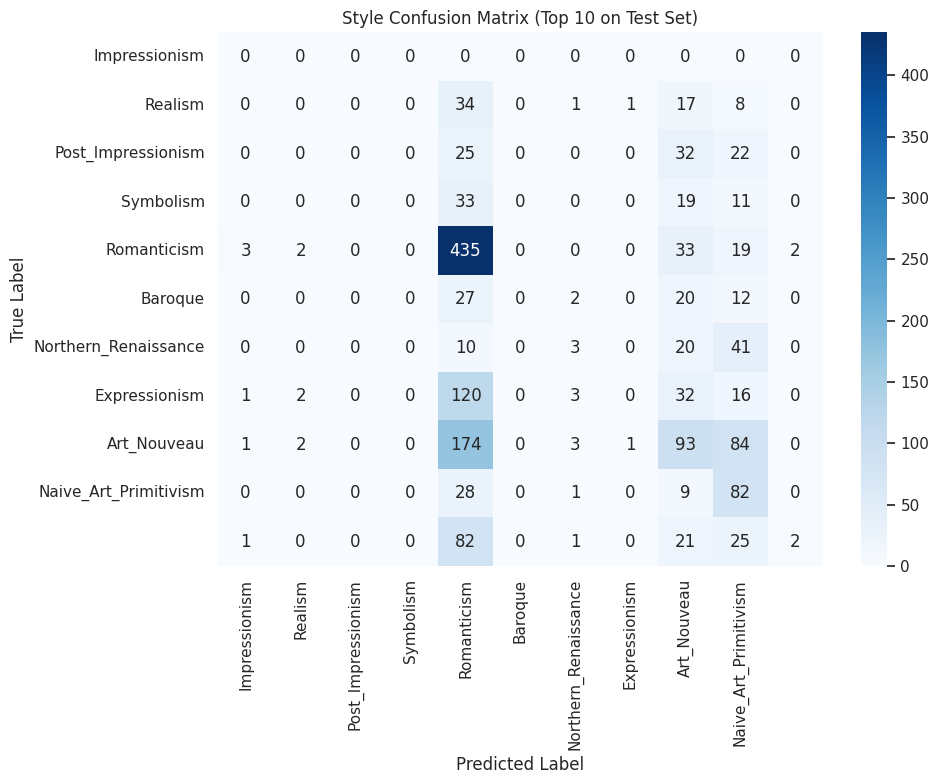


--- Outlier Detection on Test Set ---
Found 1636 potential outliers.
Top 10 outliers (lowest confidence):

+------+-----------------------------------------------------------------------------+-------------------+------------------+-----------------------+--------------------+--------------------+---------------------+------------------+
|      | filename                                                                    | style             | genre            | artist                |   style_confidence |   genre_confidence |   artist_confidence |   min_confidence |
|------+-----------------------------------------------------------------------------+-------------------+------------------+-----------------------+--------------------+--------------------+---------------------+------------------|
| 1070 | Impressionism/claude-monet_house-of-parliament-sun.jpg                      | Impressionism     | cityscape        | Claude_Monet          |        0.00013991  |        5.42156e-05 |  

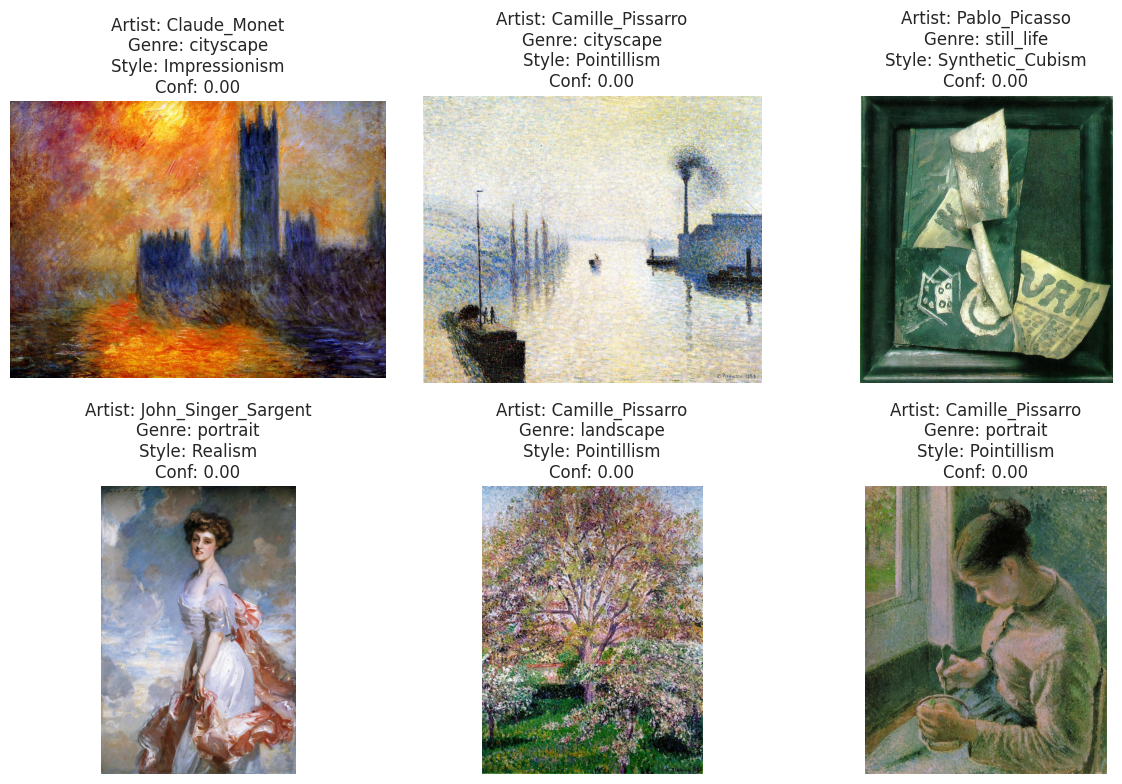

In [7]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description="Train Convolutional-Recurrent Art Classifier")
    parser.add_argument('--batch_size', type=int, default=8, help='Batch size for training')
    parser.add_argument('--epochs', type=int, default=12, help='Number of training epochs')
    parser.add_argument('--lr', type=float, default=2e-3, help='Learning rate')
    parser.add_argument('--img_size', type=int, default=224, help='Input image size')
    
    args, _ = parser.parse_known_args()
    print(f"Running on device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
    main(args)
